# `Doc2Vec.infer_vector()` に関する実験

**Sansan Builders Box**内の記事「Doc2Vecによる文章ベクトル推論の安定化について」にて言及した実験に関するノートブック

In [36]:
import MeCab
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Doc2Vec

%matplotlib inline
plt.style.use("ggplot")

import warnings
warnings.filterwarnings('ignore')

In [10]:
MODELPATH="PATH TO D2V MODEL"
NEOLOGD="PATH TO DICTIONARY DIR"

In [11]:
d2v = Doc2Vec.load(MODELPATH)
mecab = MeCab.Tagger(f'-Owakati -d {NEOLOGD}')

---

## 何回内部のtrain処理を反復したら結果は安定するのか

- 同一文章に対するinfer_vector()を2度行いそのcos類似度を算出することで安定性を計測出来るのではないか。
- 理想はcos類似度=1である (同一のベクトル)
- 実際はそうではないことが報告されているので，そのcos類似度がinfer_vector()内部のiteration回数(epochs)でどれほど近づくのかを計測する。



- サンプル文章 : https://jp.sansan.com/?trflg=1

```
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。
高度なAI技術により、会社・人物単位で名刺情報を管理できるため、
昇進や異動などの人事異動情報も自動で集約。
正確な人物データを共有できるので、社内に眠る人脈を全社で有効活用することができます。
```

上記のサンプル文書に対し，2度 `infer_vector(epochs=N)` し， 結果に対して**cos類似度**を算出。
このイテレーション回数`N`によってその類似度がどう変化するかを確認。

また， 異なった文書についてきちんと異なったベクトルを振れるかも確認。

In [45]:
s = mecab.parse(
"""
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。
高度なAI技術により、会社・人物単位で名刺情報を管理できるため、
昇進や異動などの人事異動情報も自動で集約。
正確な人物データを共有できるので、社内に眠る人脈を全社で有効活用することができます。
"""
).split()

print(s)

['名刺', 'を', '企業', 'の', '資産', 'に', '変える', '最高', '精度', 'の', '「', 'AI', '名刺', '管理', '」', 'AI', '+', '手入力', 'で', '名刺', 'を', 'ほぼ', '100%', '正確', 'に', 'データ化', '。', '高度', 'な', 'AI', '技術', 'により', '、', '会社', '・', '人物', '単位', 'で', '名刺', '情報', 'を', '管理', 'できる', 'ため', '、', '昇進', 'や', '異動', 'など', 'の', '人事異動', '情報', 'も', '自動', 'で', '集約', '。', '正確', 'な', '人物', 'データ', 'を', '共有', 'できる', 'ので', '、', '社内', 'に', '眠る', '人脈', 'を', '全社', 'で', '有効活用', 'する', 'こと', 'が', 'でき', 'ます', '。']


cos類似度計算と指定された`epochs`数での`infer_vector()`実行を100回行う関数

In [84]:
def cos_sim(v1, v2) -> float:
    """Cosine similarity"""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


# 同一文書のcos類似度算出を100回行う
def check(n_epoch=1, words=None) -> list:
    """Returns array of 100 cosine similarities"""
    res = []
    if words is not None:
        s = words
    for i in range(100):
        a = d2v.infer_vector(s, epochs=n_epoch)
        b = d2v.infer_vector(s, epochs=n_epoch)
        res.append(cos_sim(a, b))
    return np.array(res)

epochs数を, 1, 10, 100, 200 で比較してみる。

In [50]:
%%time

df = pd.DataFrame(np.array([check(), check(10), check(100), check(200)]).T)
df.columns = ["1 epoch", "10 epoch", "100 epoch", "200 epoch"]

CPU times: user 9.75 s, sys: 753 ms, total: 10.5 s
Wall time: 10.5 s


In [51]:
df.head()

,1 epoch,10 epoch,100 epoch,200 epoch
0,0.945137,0.983040,0.993708,0.995241
1,0.946987,0.984025,0.993694,0.995637
2,0.940711,0.982711,0.994227,0.995188
3,0.945149,0.983520,0.992885,0.994967
4,0.928651,0.983303,0.994177,0.996350


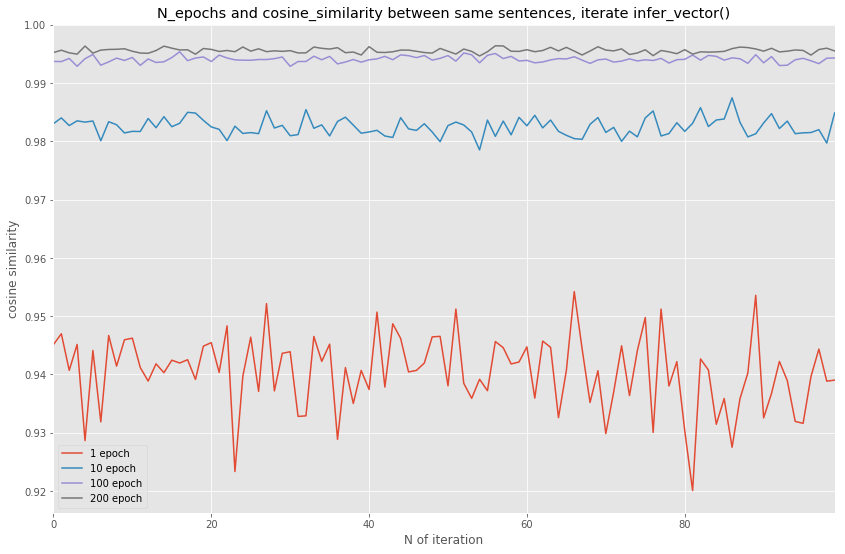

In [52]:
title="N_epochs and cosine_similarity between same sentences, iterate infer_vector()"

fig = plt.figure()
ax = df.plot(title=title,
        figsize=(14, 9), grid=True)
ax.set_xlabel("N of iteration")
ax.set_ylabel("cosine similarity")
plt.savefig(f"{title}.png")

### epochs数の推移とcos類似度の上昇の推移を調べる

In [53]:
l = np.linspace(1, 9, 9).astype(int)
l = list(l) + list(range(10, 210, 10))

In [54]:
mean = []
var = []

for i in tqdm(l):
    res = check(i)
    mean.append(res.mean())
    var.append(res.var())

100%|██████████| 29/29 [01:14<00:00,  5.79s/it]


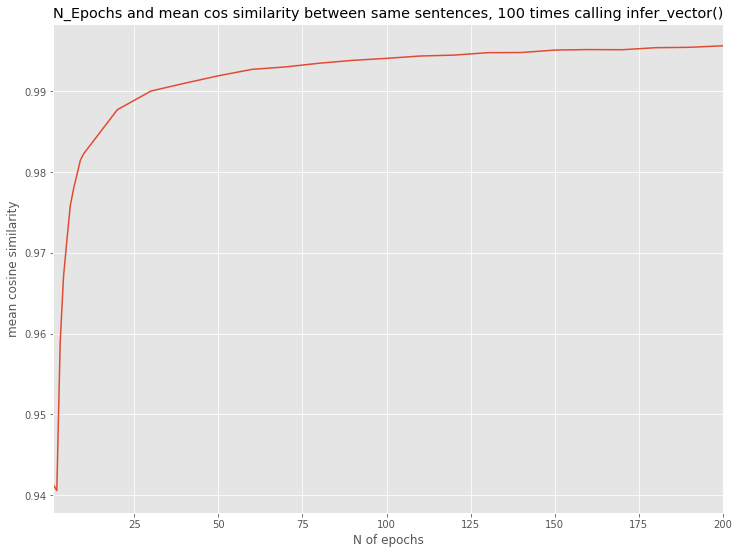

In [55]:
df_mean = pd.DataFrame([mean, l]).T
df_mean.index = df_mean[1]
fig = plt.figure()
ax = df_mean[0].plot(title="N_Epochs and mean cos similarity between same sentences, 100 times calling infer_vector()",
                     figsize=(12, 9), grid=True)
ax.set_xlabel("N of epochs")
ax.set_ylabel("mean cosine similarity")
plt.savefig("N_Epochs and mean cos similarity between same sentences, 100 times calling infer_vector().png")

上記のように， `epochs=30`程度で100回試行した際のcos類似度の平均は0.99に落ち着く。

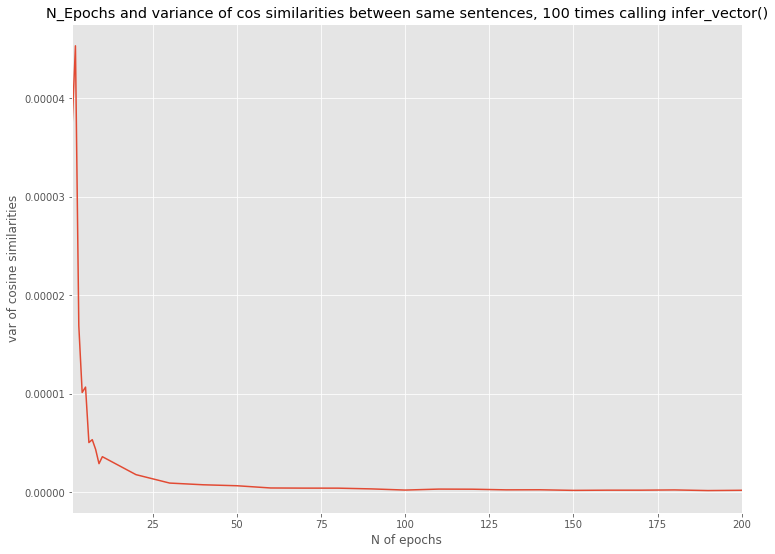

In [56]:
df_var = pd.DataFrame([var, l]).T
df_var.index = df_var[1]
fig = plt.figure()
ax = df_var[0].plot(title="N_Epochs and variance of cos similarities between same sentences, 100 times calling infer_vector()",
           figsize=(12, 9), grid=True)
ax.set_xlabel("N of epochs")
ax.set_ylabel("var of cosine similarities")
plt.savefig("N_Epochs and variance of cos similarities between same sentences, 100 times calling infer_vector().png")

### Livedoorニュースコーパス Sports Watch の文章で試す。

In [12]:
import re

def clean_sportswatch_txt(s: str) -> str:
    s = s.replace("\nT\n【Sports Watch】", "")
    # url除去
    s = re.sub(r"(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+)", "" , s)
    s = re.sub(re.compile("[\d!-/:-@[-`{-~]"), '', s)
    return s

In [57]:
from glob import glob
from tqdm import tqdm


corpus_dir = "/Volumes/Work/atsuya/livedoor_news_corpus/"

documents = []
for directry in glob(f"{corpus_dir}*"):
    for file in tqdm(glob(f"{directry}/*.txt"), leave=True):
        with open(file, "r") as f:
            documents.append(
                [directry.split("/")[-1], clean_sportswatch_txt(f.read())])

            
documents = pd.DataFrame(documents)
documents.columns = ["label", "sentence"]

0it [00:00, ?it/s]
100%|██████████| 865/865 [00:00<00:00, 16998.01it/s]
0it [00:00, ?it/s]
100%|██████████| 871/871 [00:00<00:00, 11046.12it/s]


In [58]:
documents.head()

,label,sentence
0,sports-watch,\nT\n【Sports Watch】内田篤人、好きな女性芸能人を前に「真っ白なんですけど」...
1,sports-watch,\nT\n【Sports Watch】新大関・把瑠都、突っ張り開眼も「申し訳ない」\n史上初...
2,sports-watch,\nT\n【Sports Watch】雄星との間に何があった デーブ大久保氏「これが暴行って...
3,sports-watch,\nT\n横浜ベイ新球団名に疑問の声 「企業名なら売名行為にならないの？」\n携帯用ゲームサ...
4,sports-watch,\nT\n【Sports Watch】全治カ月、代表入りが危ぶまれる丸山にかけた澤の言葉とは...


単語数の分布を確認

In [154]:
%%time

lengthes = pd.Series([len(mecab.parse(s).split()) for s in documents.sentence])

CPU times: user 4.02 s, sys: 62.7 ms, total: 4.08 s
Wall time: 4.2 s


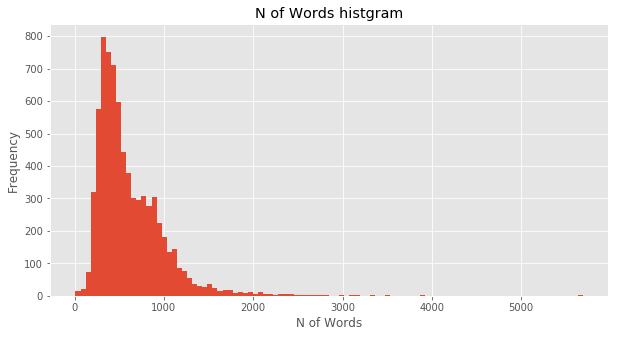

In [155]:
title = "N of Words histgram"

fig = plt.figure()
ax = lengthes.plot(kind="hist", bins=100, 
                   title=title, figsize=(10, 5), grid=True)
ax.set_xlabel("N of Words")
plt.savefig(f"img/{title}.png")

In [156]:
print(f"mean: {np.mean(lengthes)} ± {np.std(lengthes)}") 

mean: 610.2744034707158 ± 367.48873228690013


In [157]:
max(lengthes)

5688

ランダムで選択したニュース文章に対して同様の実験を行う

In [71]:
import random

s = mecab.parse(random.choice(documents.sentence.values)).split()
print(s)

['T', '孫社長', 'が', '新', 'スマホ', 'を', '大々的', 'に', '宣伝', '！', '放射線', '測定', 'スマホ', 'を', '開発', 'し', 'た', '理由', 'ソフトバンクグループ', 'の', '代表', '孫正義', '氏', 'は', '、', 'Twitter', 'を通じて', '活発', 'な', '発言', 'を', 'し', 'て', 'いる', '。', 'そんな', '同氏', 'の', '放射線', '測定', '機能', '付き', 'スマホ', 'に関する', '発言', 'が', 'ネットで話題', 'と', 'なっ', 'て', 'いる', '。', 'それ', 'は', '、', '突然', 'の', 'つぶやき', 'から', '始まっ', 'た', '。', '孫社長', 'は', '、', '「', '放射線', '測定', '機能', '搭載', 'スマホ', '出来', 'まし', 'た', '。', '昨日', 'から', '発売', '。', 'プラチナバンド', '対応', '。', '基本', '料', '無料', 'キャンペーン', 'も', '実施中', '。', '」', 'と', '、', 'つぶやい', 'た', '。', 'これ', 'に対して', '、', '「', '計測', '精度', 'は', 'どれ', 'くらい', 'な', 'の', 'かしら', '？', '」', 'と', 'の', '問い合わせ', 'が', 'Twitter', '読者', 'から', 'あり', '、', '孫社長', 'は', '「', '〜', '数', '万', '円', 'で', '販売', 'さ', 'れ', 'て', 'いる', '市販', 'の', '計測器', '程度', 'の', '精度', 'です', '。', '」', '「', '〜', '数', '万', '円', 'で', '販売', 'さ', 'れ', 'て', 'いる', '市販', 'の', '計測器', '程度', 'の', '精度', 'です', '。', '」', '「', '感度', 'は', '下記', 'です', '。', '」', 'と', '、', '回答', 'し'

In [72]:
%%time

df = pd.DataFrame(np.array([check(), check(10), check(100), check(200)]).T)
df.columns = ["1 epoch", "10 epoch", "100 epoch", "200 epoch"]

CPU times: user 1min 7s, sys: 1.24 s, total: 1min 8s
Wall time: 1min 8s


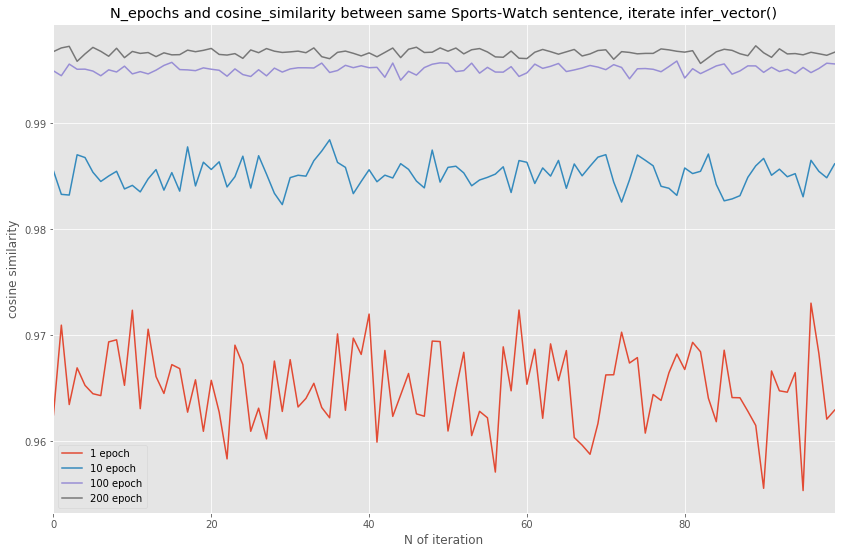

In [73]:
title="N_epochs and cosine_similarity between same Sports-Watch sentence, iterate infer_vector()"

fig = plt.figure()
ax = df.plot(title=title,
        figsize=(14, 9), grid=True)
ax.set_xlabel("N of iteration")
ax.set_ylabel("cosine similarity")
plt.savefig(f"{title}.png")

大方同様の結果が得られた。

## 文章長と同一文書cos類似度の関連

まずは先程のサンプルテキストを用いて文章長(単語数)による結果の違いを調査する。

- 単語 (N=1)
- 合成後 (N=2)
- フレーズ (N=3~5)
- それ以上 (10, 100単語刻みで調査)

ができればよいかと。

In [76]:
sample = mecab.parse("""
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。
高度なAI技術により、会社・人物単位で名刺情報を管理できるため、
昇進や異動などの人事異動情報も自動で集約。
正確な人物データを共有できるので、社内に眠る人脈を全社で有効活用することができます。
""").split()

In [102]:
sentences = []

- 単語

In [114]:
s1 = [sample[0]]
s1

['名刺']

- 合成語

In [108]:
s2 = sample[12:14]
s2

['名刺', '管理']

- フレーズ

In [109]:
s3 = sample[38:42]
s3

['名刺', '情報', 'を', '管理']

- それ以上は，文の数毎に変える。

In [100]:
s4 = mecab.parse("""
名刺を企業の資産に変える最高精度の「AI名刺管理」""").split()

s5 = mecab.parse("""
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。""").split()

s6 = mecab.parse("""
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。
高度なAI技術により、会社・人物単位で名刺情報を管理できるため、""").split()

s7 = mecab.parse("""
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。
高度なAI技術により、会社・人物単位で名刺情報を管理できるため、
昇進や異動などの人事異動情報も自動で集約。""").split()

s8 = mecab.parse("""
名刺を企業の資産に変える最高精度の「AI名刺管理」
AI+手入力で名刺をほぼ100%正確にデータ化。
高度なAI技術により、会社・人物単位で名刺情報を管理できるため、
昇進や異動などの人事異動情報も自動で集約。
正確な人物データを共有できるので、社内に眠る人脈を全社で有効活用することができます。""").split()

In [161]:
sentences = [s1, s2, s3, s4, s5, s6, s7, s8]

これ以上の単語数のものはコーパスから取得する。

200, 500, 1000, 5000程度を取得。

In [162]:
sentences.append(mecab.parse(
    documents.sentence[
        lengthes[(195 < lengthes) & (lengthes < 205)].index[0]]).split())

sentences.append(mecab.parse(
    documents.sentence[
        lengthes[(495 < lengthes) & (lengthes < 505)].index[0]]).split())

sentences.append(mecab.parse(
    documents.sentence[
        lengthes[(995 < lengthes) & (lengthes < 1005)].index[0]]).split())

sentences.append(mecab.parse(
    documents.sentence[np.argmax(lengthes)]).split())

各用意した文章のそれぞれの長さは以下の通り。

In [163]:
[len(s) for s in sentences]

[1, 2, 4, 15, 27, 45, 57, 80, 202, 500, 1002, 5688]

各単語数に対して， cos類似度の100試行平均と分散を計測する。

In [165]:
means = []
variances = []

for S in tqdm(sentences):
    mean = []
    var = []
    for i in [5, 10, 20, 30, 40, 50, 100, 200]:
        res = check(i, S)
        mean.append(res.mean())
        var.append(res.var())
    means.append(mean)
    variances.append(var)


100%|██████████| 12/12 [20:38<00:00, 326.89s/it]


In [169]:
means_df = pd.DataFrame(means).T
variances_df = pd.DataFrame(variances).T

In [193]:
means_df

,1,2,4,15,27,45,57,80,202,500,1002,5688
5,0.722478,0.820017,0.866034,0.925394,0.950372,0.964841,0.967421,0.972440,0.976963,0.976465,0.981632,0.982522
10,0.834761,0.892667,0.921614,0.956934,0.970614,0.978426,0.980165,0.982435,0.983135,0.982889,0.986351,0.988173
20,0.906711,0.938283,0.954405,0.975540,0.981688,0.985473,0.986837,0.987823,0.987634,0.987663,0.990070,0.992033
30,0.930616,0.956820,0.967861,0.981743,0.985697,0.988148,0.988924,0.989858,0.989842,0.990174,0.991779,0.993658
40,0.944346,0.964725,0.973040,0.984508,0.987983,0.989682,0.990307,0.991020,0.990995,0.991414,0.992812,0.994386
50,0.954782,0.970714,0.977303,0.986587,0.989207,0.990548,0.991151,0.992056,0.991903,0.992340,0.993513,0.994976
100,0.972223,0.981996,0.985595,0.990800,0.992292,0.993089,0.993384,0.994108,0.994043,0.994608,0.995515,0.996241
200,0.981984,0.988562,0.990152,0.993001,0.994256,0.994916,0.995117,0.995525,0.995291,0.996275,0.996905,0.997106


In [191]:
variances_df

,1,2,4,15,27,45,57,80,202,500,1002,5688
5,0.001014,0.000359,0.000205,6.218003e-05,2.706436e-05,1.279180e-05,1.076724e-05,6.643344e-06,4.211719e-06,4.880102e-06,2.920720e-06,4.449667e-06
10,0.000304,0.000122,0.000078,2.031355e-05,9.901390e-06,4.930584e-06,3.480395e-06,3.072479e-06,2.809601e-06,2.700039e-06,1.845636e-06,2.876021e-06
20,0.000106,0.000043,0.000033,5.790138e-06,3.146668e-06,1.277475e-06,1.870184e-06,1.401852e-06,1.466965e-06,1.234966e-06,9.919855e-07,7.939398e-07
30,0.000038,0.000023,0.000014,3.696902e-06,2.353460e-06,1.450504e-06,1.248887e-06,9.908948e-07,7.431117e-07,8.955267e-07,7.121230e-07,4.446727e-07
40,0.000032,0.000016,0.000006,2.407508e-06,1.451892e-06,1.175359e-06,8.092317e-07,8.053359e-07,7.654715e-07,5.185992e-07,4.119168e-07,4.071162e-07
50,0.000026,0.000009,0.000005,1.588234e-06,1.124007e-06,1.194559e-06,6.835637e-07,5.110938e-07,5.203436e-07,4.647085e-07,2.891182e-07,4.134062e-07
100,0.000010,0.000004,0.000003,7.902121e-07,3.746781e-07,6.174996e-07,4.355202e-07,3.560457e-07,2.600475e-07,2.181201e-07,1.385012e-07,4.413936e-07
200,0.000004,0.000001,0.000001,5.919090e-07,3.032064e-07,2.819877e-07,2.028470e-07,1.845846e-07,2.365961e-07,1.255963e-07,7.898399e-08,4.316745e-07


In [192]:
means_df.columns = [len(s) for s in sentences]
means_df.index = [5, 10, 20, 30, 40, 50, 100, 200]

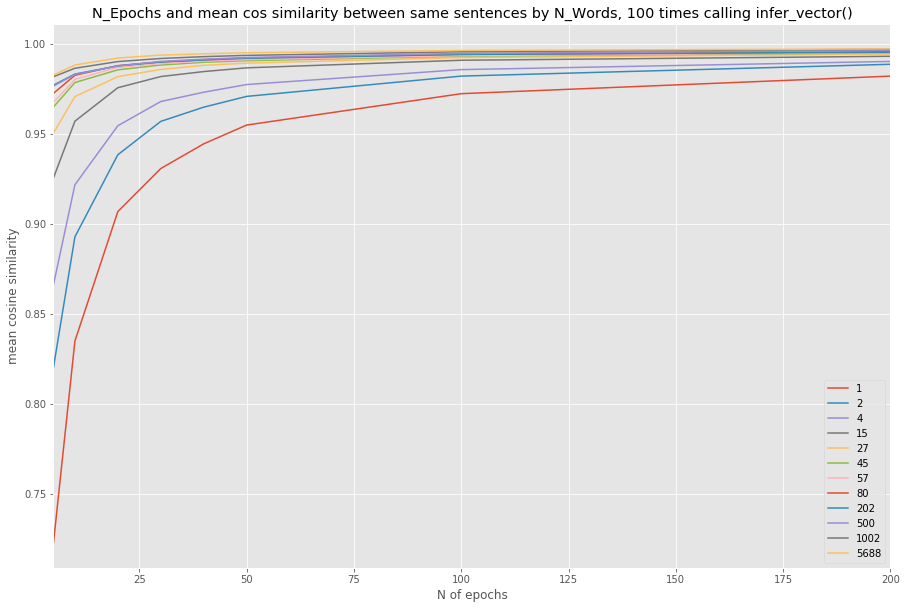

In [174]:
title = "N_Epochs and mean cos similarity between same sentences by N_Words, 100 times calling infer_vector()"

fig = plt.figure()
ax = means_df.plot(title=title, figsize=(15, 10), grid=True)
ax.set_xlabel("N of epochs")
ax.set_ylabel("mean cosine similarity")
plt.savefig(title + ".png")

In [175]:
variances_df.columns = [len(s) for s in sentences]
variances_df.index = [5, 10, 20, 30, 40, 50, 100, 200]

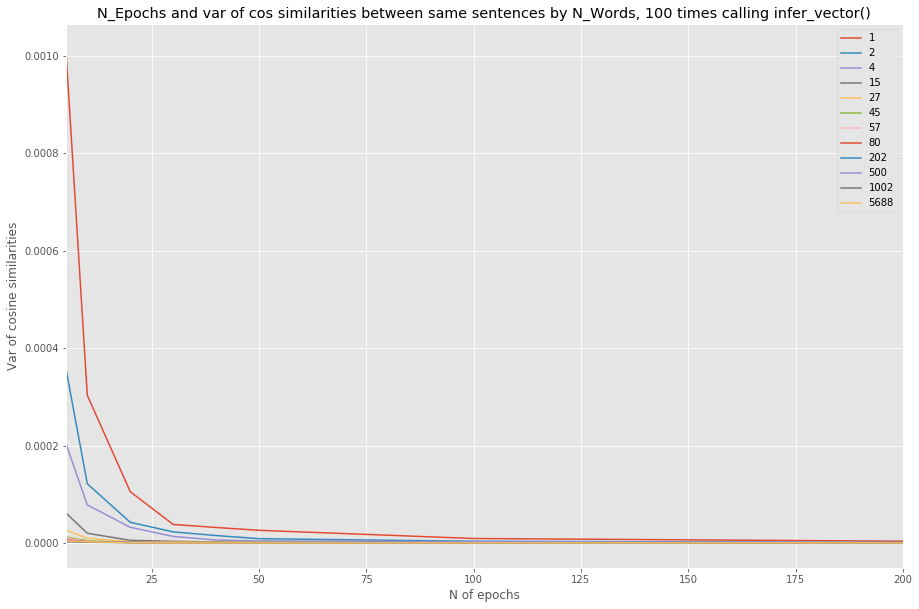

In [177]:
title = "N_Epochs and var of cos similarities between same sentences by N_Words, 100 times calling infer_vector()"

fig = plt.figure()
ax = variances_df.plot(title=title, figsize=(15, 10), grid=True)
ax.set_xlabel("N of epochs")
ax.set_ylabel("Var of cosine similarities")
plt.savefig(title + ".png")

In [189]:
d2v.wv.most_similar("サッカー")

[('フットサル', 0.7777404189109802),
 ('フットボール', 0.7727267146110535),
 ('少年サッカー', 0.7433319091796875),
 ('女子サッカー', 0.7351254224777222),
 ('高校サッカー', 0.726090669631958),
 ('サッカーチーム', 0.7176849842071533),
 ('バレーボール', 0.7045983076095581),
 ('ゴールキーパー', 0.6908824443817139),
 ('Jリーガー', 0.685981273651123),
 ('日本サッカー協会', 0.6841729879379272)]

## Livedoorニュースコーパス全体に適応できるかの調査

ランダムに100件取得し，それらの文書に対してのcos類似度算出を行う。

In [196]:
S = [mecab.parse(sentence).split() for sentence in tqdm(np.random.choice(documents.sentence, 100))]

100%|██████████| 100/100 [00:00<00:00, 912.70it/s]


単語数分布

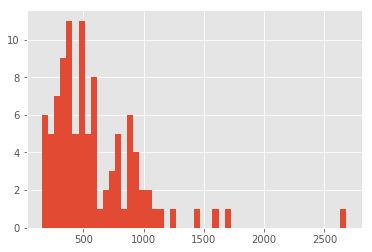

In [202]:
plt.hist([len(s) for s in S], bins=50)
None

In [203]:
def check_corpus(n_epoch=1) -> list:
    """Returns array of 100 cosine similarities"""
    res = []
    for s in S:
        a = d2v.infer_vector(s, epochs=n_epoch)
        b = d2v.infer_vector(s, epochs=n_epoch)
        res.append(cos_sim(a, b))
    return np.array(res)

In [205]:
%%time

df = pd.DataFrame(np.array([check_corpus(), check_corpus(10),
                            check_corpus(100), check_corpus(200)]).T)
df.columns = ["1 epoch", "10 epoch", "100 epoch", "200 epoch"]

CPU times: user 1min 3s, sys: 1.09 s, total: 1min 4s
Wall time: 1min 4s


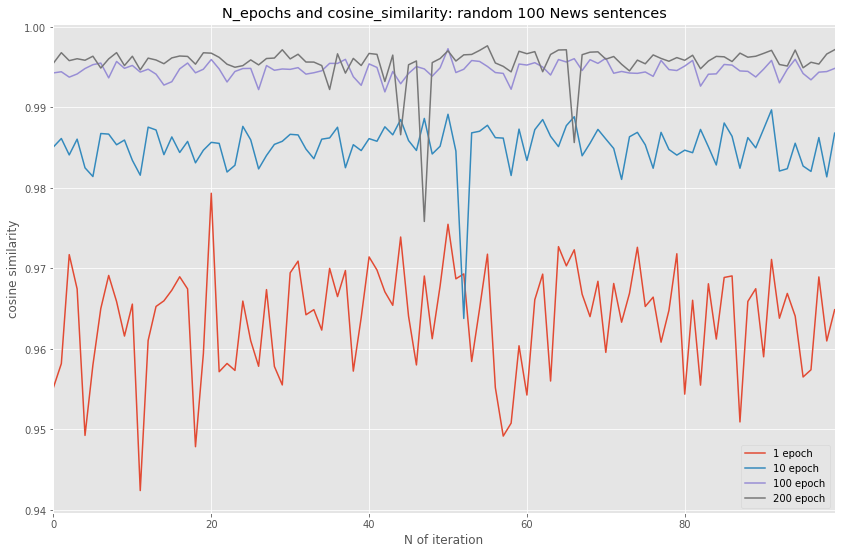

In [208]:
title="N_epochs and cosine_similarity: random 100 News sentences"

fig = plt.figure()
ax = df.plot(title=title,
        figsize=(14, 9), grid=True)
ax.set_xlabel("N of iteration")
ax.set_ylabel("cosine similarity")
plt.savefig(f"{title}.png")

In [207]:
mean = []
var = []

for i in tqdm(l):
    res = check_corpus(i)
    mean.append(res.mean())
    var.append(res.var())

100%|██████████| 29/29 [07:27<00:00, 36.56s/it]


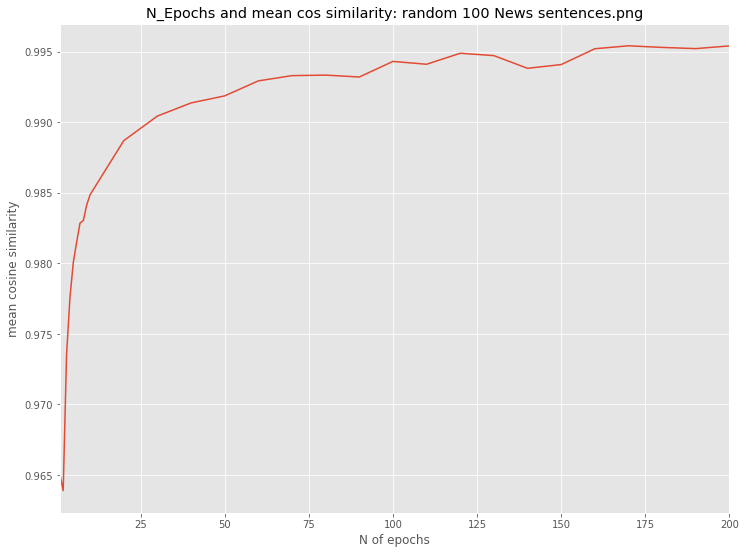

In [209]:
df_mean = pd.DataFrame([mean, l]).T
df_mean.index = df_mean[1]
fig = plt.figure()
ax = df_mean[0].plot(title="N_Epochs and mean cos similarity: random 100 News sentences.png",
                     figsize=(12, 9), grid=True)
ax.set_xlabel("N of epochs")
ax.set_ylabel("mean cosine similarity")
plt.savefig("N_Epochs and mean cos similarity: random 100 News sentences.png")

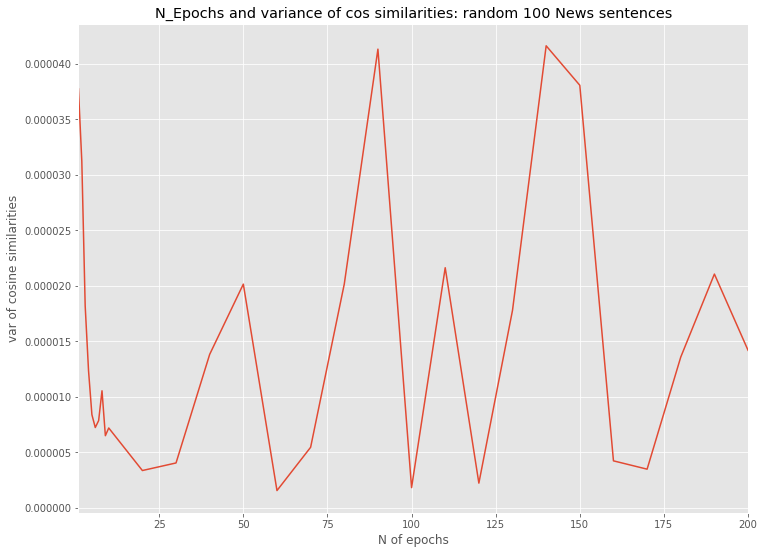

In [210]:
df_var = pd.DataFrame([var, l]).T
df_var.index = df_var[1]
fig = plt.figure()
ax = df_var[0].plot(title="N_Epochs and variance of cos similarities: random 100 News sentences",
           figsize=(12, 9), grid=True)
ax.set_xlabel("N of epochs")
ax.set_ylabel("var of cosine similarities")
plt.savefig("N_Epochs and variance of cos similarities: random 100 News sentences.png")